# Basic image anaylsis tutorial

This notebook documents basic (astronomical) image analysis with python.

In [1]:
# import the modules we need

from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from  astropy.visualization import make_lupton_rgb 
import matplotlib.pyplot as plt

Define where the image files are and what filters we have available

In [2]:

# the directory containing the images relative to this workbook 
image_dir = '../test_data/'

# list of filters 
filters = ['f115w', 'f150w', 'f200w', 'f277w', 'f356w', 'f444w']


Open the first image. The data is stored in a multi-extension FITS file. Essentially, in this case, the file contains three different image arrays:

- SCI: the science map, essentially a 2D array of the flux 
- ERR: the error map, an estimate of the error on every pixel
- WHT: the weight map

In [3]:

# open the i2d image file
hdul = fits.open(f"{image_dir}/{filters[0]}_i2d.fits")

# get info - 
hdul.info()


Filename: ../test_data//f115w_i2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SCI           1 ImageHDU        39   (200, 200)   float32   
  2  ERR           1 ImageHDU        39   (200, 200)   float32   
  3  WHT           1 ImageHDU        39   (200, 200)   float32   


### Explore the science map

(200, 200)
XTENSION IMAGE
BITPIX -32
NAXIS 2
NAXIS1 200
NAXIS2 200
PCOUNT 0
GCOUNT 1
EXTNAME SCI
WCSAXES 2
CRPIX1 26279.5
CRPIX2 -923.5
PC1_1 -0.64678977951046
PC1_2 -0.76266832969569
PC2_1 -0.76266832969569
PC2_2 0.64678977951046
CDELT1 8.3333333333333e-06
CDELT2 8.3333333333333e-06
CUNIT1 deg
CUNIT2 deg
CTYPE1 RA---TAN
CTYPE2 DEC--TAN
CRVAL1 214.825
CRVAL2 52.825
LONPOLE 180.0
LATPOLE 52.825
MJDREF 0.0
DATE-BEG 2022-06-21T18:09:46.649
MJD-BEG 59751.756789922
DATE-AVG 2022-06-21T19:19:05.420
MJD-AVG 59751.804923837
DATE-END 2022-06-21T20:27:34.055
MJD-END 59751.852477488
XPOSURE 49475.04
TELAPSE 49475.04
OBSGEO-X 362899179.14001
OBSGEO-Y -1339357702.7182
OBSGEO-Z -1035769565.0583
RADESYS ICRS
VELOSYS 14501.05


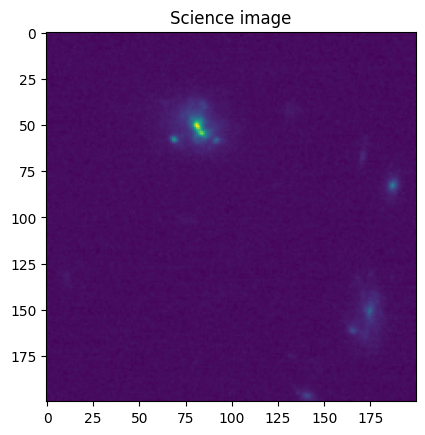

In [6]:

# grab the extension holding the science image
hdu = hdul['SCI']

# print the shape of the science image
print(hdu.data.shape)

# print the header keywords
for key, value in hdu.header.items():
    print(key, value)

# plot the data
plt.imshow(hdu.data)
plt.title("Science image")
plt.show()


The colours in this image are arbitrary. 

### Making the RGB image
Now making a colour image using filters corresponding to RGB colour values.

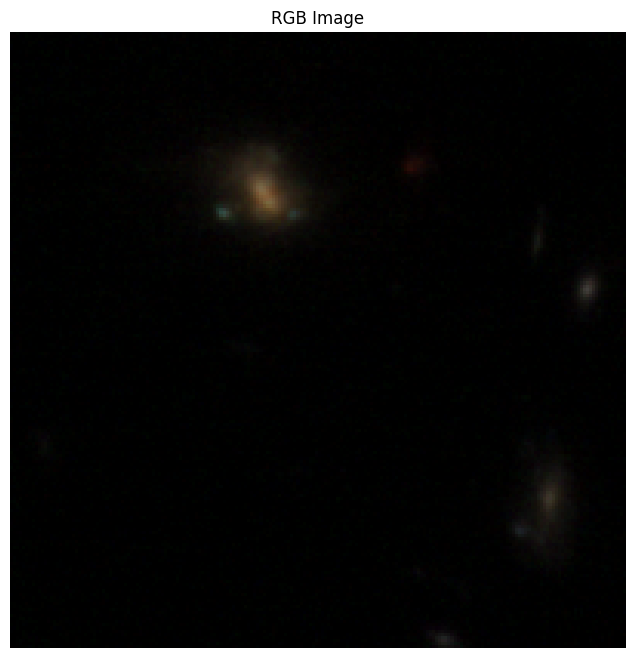

In [8]:



RGB=['f200w','f150w','f115w'] #These are will be the filters we will use to represent RGB colours respectively.
RGB_maps=[] # A list to contain the three RGB maps.
WT=[1,1,1] #This will allow the adjustment of the colour levels.
Brightness=1 #Will just allow for brightness adjustment of image

counter=0
for n in range(len(RGB)): #Looping over the fiters and extracting the data for the colours.
    temp=fits.open(f"{image_dir}/{RGB[counter]}_i2d.fits")
    RGB_maps.append(temp["SCI"].data)
    counter=counter+1
   


#Next we will be combing all our 3 maps together to create our final RGB image.
img=make_lupton_rgb(image_r=RGB_maps[0]*WT[0],image_g=RGB_maps[1]*WT[1],image_b=RGB_maps[2]*WT[2],minimum=0,stretch=1) 

img[img<0.0] = 0.0  #Exclude negative pixels



fig1,ax1=plt.subplots(1,1,figsize=(8,8)) #Setting up the image space
img=img*Brightness  #Adjusting for brightness for visual clarity
ax1.imshow(img)
ax1.set_title("RGB Image")
ax1.set_axis_off()
plt.show()

